In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import xgboost as xgb
import sklearn.metrics as mtr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import dataframe_image as dfi
import pytz

# Exploração e Tratamento dos dados

In [35]:
df = pd.read_csv('dados_floripa.csv')
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\2996573664.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados_floripa.csv')


,DataIni,HoraIni,DataFim,HoraFim,Sentido,Linha,NoVeículo,DuraçãoViagem,TotalGiros,KmPerc
0,2019-04-14,02:29:00,2019-04-14,02:30:00,Ida,100,271,00:01:00,0,0.000
1,2019-04-14,03:30:00,2019-04-14,03:30:00,Ida,100,271,00:00:00,0,0.000
2,2019-04-13,01:28:00,2019-04-13,01:28:00,Ida,100,276,00:00:00,0,0.000
3,2019-04-12,03:28:00,2019-04-12,03:28:00,Ida,100,279,00:00:00,0,0.000
4,2019-04-07,00:31:00,2019-04-07,00:31:00,Ida,100,273,00:00:00,0,0.000
...,...,...,...,...,...,...,...,...,...,...
2694355,2019-10-01,04:00:00,2019-10-01,04:34:00,Volta,477,50404,00:34:00,5,17.294
2694356,2019-10-01,04:29:00,2019-10-01,05:12:00,Volta,477,50359,00:43:00,7,17.294
2694357,2019-10-01,05:15:00,2019-10-01,05:47:00,Volta,477,50404,00:32:00,7,17.294
2694358,2019-10-01,05:47:00,2019-10-01,05:47:00,Volta,477,50404,00:00:00,0,17.294


In [36]:
# Checar o tipos dos dados
df.dtypes

DataIni           object
HoraIni           object
DataFim           object
HoraFim           object
Sentido           object
Linha             object
NoVeículo         object
DuraçãoViagem     object
TotalGiros         int64
KmPerc           float64
dtype: object

In [37]:
# Checkup geral das colunas
# Podemos ver num primeiro momento que:
# Sentido está de certa forma balanceado no geral, verificar se para todas as rotas também está próximo
# Existem 229 linhas que podem ser trabalhadas (objeto do estudo)
# Existem 1295 veículos, pode existir alguma relação do veículo com a eficiência/velocidade da rota, porém como não sabemos quem dirige o ônibus ou informações do mesmo como estado de manutenção e etc, provavelmente será um dado descartado
# Algumas rotas estão com KmPerc zerados, podem ser falhas de medição e serão descartados
# Algumas rotas estão com o tempo de viagem zerados, podem ser falhas de medição e serão descartados
# TotalGiros são o número de pessoas que passaram pela roleta podem influenciar na DuraçãoViagem das rotas, algumas estão zeradas podendo ser falha de medição
for colum in df:
    print(f'{df[colum].describe()}\n--------------------------')

count        2694360
unique           366
top       2019-10-25
freq            9276
Name: DataIni, dtype: object
--------------------------
count      2694360
unique        1440
top       07:00:00
freq          4366
Name: HoraIni, dtype: object
--------------------------
count        2694360
unique           366
top       2019-10-25
freq            9275
Name: DataFim, dtype: object
--------------------------
count      2694360
unique        1440
top       07:15:00
freq          3969
Name: HoraFim, dtype: object
--------------------------
count     2694360
unique          2
top         Volta
freq      1394073
Name: Sentido, dtype: object
--------------------------
count     2694360
unique        230
top           410
freq        68613
Name: Linha, dtype: object
--------------------------
count     2694360
unique       1301
top         11637
freq         8487
Name: NoVeículo, dtype: int64
--------------------------
count      2694360
unique         454
top       00:21:00
freq         819

In [38]:
# Id do veículos consideramos que é um informação desnecessária, visto que não temos dados dos veículos em si como modelo, motor e etc. Assim acreditamos ser um dados desnecessário para a predição
df.drop(columns='NoVeículo',inplace=True)

In [39]:
# Unindo data e hora e removendo as antigas (Visto que as datas e horas atuais estão em colunas separadas e são objetos, queremos elas como datetimes)
df['Ini'] = pd.to_datetime(df['DataIni'] + ' ' + df['HoraIni'])
df['Fim'] = pd.to_datetime(df['DataFim'] + ' ' + df['HoraFim'])
df.drop(columns=['DataIni','HoraIni','DataFim','HoraFim'],inplace=True)

In [40]:
# Transformando a DuraçãoViagem em segundos, visto que é um objeto também
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_seconds = (hours * 3600) + (minutes * 60) + seconds
    return total_seconds
df['DuraçãoViagem'] = df['DuraçãoViagem'].apply(time_to_seconds)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim
0,Ida,100,60,0,0.000,2019-04-14 02:29:00,2019-04-14 02:30:00
1,Ida,100,0,0,0.000,2019-04-14 03:30:00,2019-04-14 03:30:00
2,Ida,100,0,0,0.000,2019-04-13 01:28:00,2019-04-13 01:28:00
3,Ida,100,0,0,0.000,2019-04-12 03:28:00,2019-04-12 03:28:00
4,Ida,100,0,0,0.000,2019-04-07 00:31:00,2019-04-07 00:31:00
...,...,...,...,...,...,...,...
2694355,Volta,477,2040,5,17.294,2019-10-01 04:00:00,2019-10-01 04:34:00
2694356,Volta,477,2580,7,17.294,2019-10-01 04:29:00,2019-10-01 05:12:00
2694357,Volta,477,1920,7,17.294,2019-10-01 05:15:00,2019-10-01 05:47:00
2694358,Volta,477,0,0,17.294,2019-10-01 05:47:00,2019-10-01 05:47:00


In [41]:
# Removendo linhas com Duração e Distância percorridas iguais a 0
df = df.loc[(df['DuraçãoViagem'] != 0) & (df['KmPerc'] != 0)]

In [42]:
# Criando uma coluna de Velocidade para identificar outliers
df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
# Removendo valores muito baixos e altos de velocidade
df = df.loc[(df['Km/H'] > 3) & (df['Km/H'] < 80)]
df.drop(columns='Km/H', inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\629631639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\629631639.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='Km/H', inplace=True)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00
...,...,...,...,...,...,...,...
2694352,Volta,477,1500,1,17.294,2019-10-01 03:30:00,2019-10-01 03:55:00
2694355,Volta,477,2040,5,17.294,2019-10-01 04:00:00,2019-10-01 04:34:00
2694356,Volta,477,2580,7,17.294,2019-10-01 04:29:00,2019-10-01 05:12:00
2694357,Volta,477,1920,7,17.294,2019-10-01 05:15:00,2019-10-01 05:47:00


In [43]:
# Criando novos atributos a partir da data
df['dia_semana'] = df['Ini'].dt.dayofweek + 1
df['hora_dia'] = df['Ini'].dt.hour
df['dia_ano'] = df['Ini'].dt.dayofyear
df['mes_ano'] = df['Ini'].dt.month
df['turno_dia'] = df['hora_dia'].apply(lambda x: 1 if x < 6 else 4 if x > 17 else 2 if (x > 5 & x < 12) else 3 if (x > 11 & x < 18) else None)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\3472968728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dia_semana'] = df['Ini'].dt.dayofweek + 1
C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\3472968728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hora_dia'] = df['Ini'].dt.hour
C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\3472968728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [44]:
# Analisando e removendo Linhas que não tem observações nos 12 meses do ano
meses_linha = df.groupby('Linha')['mes_ano'].unique().reset_index(name='meses')
meses_linha['contagem'] = meses_linha['meses'].apply(lambda x: len(x))
linhas_com_12_meses = meses_linha.loc[meses_linha['contagem']==12]['Linha'].values
df = df.loc[df['Linha'].isin(linhas_com_12_meses)]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00,3,0,121,5,1
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00,3,1,121,5,1
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00,3,2,121,5,1
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00,3,3,121,5,1
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00,3,4,121,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


In [45]:
# Analisando se alguma rota tem uma discrepancia muito grande entre as observações em cada Mês. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha = df.groupby(['Linha','mes_ano'])['dia_ano'].unique().reset_index(name='dias')
dias_mes_linha['contagem'] = dias_mes_linha['dias'].apply(lambda x: len(x))
dias_mes_linha_std = dias_mes_linha.groupby('Linha')['contagem'].agg(media='mean',desvio='std').reset_index()

In [46]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha_std.sort_values(by='desvio')

,Linha,media,desvio
0,100,30.416667,0.900337
34,164,30.416667,0.900337
35,165,30.416667,0.900337
37,168,30.416667,0.900337
77,270,30.416667,0.900337
...,...,...,...
8,1120,26.166667,2.124889
10,1122,26.333333,2.188122
9,1121,26.333333,2.188122
134,601V,20.000000,3.567530


In [47]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha.loc[dias_mes_linha['Linha']=='601V']

,Linha,mes_ano,dias,contagem
1608,601V,1,"[31, 30, 29, 28, 25, 24, 23, 22, 21, 18, 17, 1...",22
1609,601V,2,"[59, 58, 57, 56, 53, 52, 51, 50, 49, 46, 45, 4...",20
1610,601V,3,"[88, 87, 86, 85, 84, 67, 66, 65, 63, 60]",10
1611,601V,4,"[120, 119, 116, 115, 114, 113, 112, 108, 107, ...",21
1612,601V,5,"[151, 150, 149, 148, 147, 144, 143, 142, 141, ...",22
1613,601V,6,"[179, 178, 177, 176, 175, 172, 170, 169, 168, ...",18
1614,601V,7,"[212, 211, 210, 207, 206, 205, 204, 203, 200, ...",23
1615,601V,8,"[242, 241, 240, 239, 238, 235, 234, 233, 232, ...",22
1616,601V,9,"[273, 270, 269, 268, 267, 266, 263, 262, 261, ...",21
1617,601V,10,"[304, 303, 302, 301, 298, 297, 296, 295, 294, ...",23


In [48]:
# Removendo as linhas com maior desvio padrão entre os meses
df = df.loc[~df['Linha'].isin(['601V','296','500V'])]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00,3,0,121,5,1
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00,3,1,121,5,1
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00,3,2,121,5,1
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00,3,3,121,5,1
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00,3,4,121,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


count      185.000000
mean     13839.216216
std      13599.364304
min        247.000000
25%       3990.000000
50%      10699.000000
75%      16809.000000
max      67327.000000
Name: Sentido, dtype: float64


Text(0, 0.5, 'Qtd. Rotas')

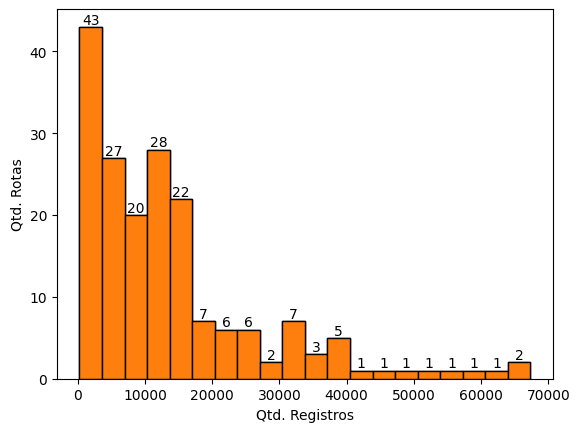

In [49]:
# Verificando a quantidade de rotas em cada Linha para removermos linhas com poucas observações ou muitas observações
qtd_rotas_p_linha = pd.DataFrame(df.groupby('Linha')['Sentido'].count())
print(qtd_rotas_p_linha['Sentido'].describe())
# Plotar o histograma
plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')  # 'data' são os dados, 'bins' é o número de intervalos
# Adicionar rótulos com o número de itens em cada bin
hist, bins, _ = plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], str(int(hist[i])),ha='center', va='bottom')
plt.xlabel('Qtd. Registros')  # Rótulo do eixo x
plt.ylabel('Qtd. Rotas')  # Rótulo do eixo y
# Exibir o histograma
# plt.show()

In [50]:
# Removendo as linhas com quantidade de rotas fora do primeiro e terceiro quartil
rotas_entre_primeiro_terceiro_qaurtil = qtd_rotas_p_linha.loc[(qtd_rotas_p_linha['Sentido'] > 3900)&(qtd_rotas_p_linha['Sentido']<16900)].index.values
df = df.loc[df['Linha'].isin(rotas_entre_primeiro_terceiro_qaurtil)]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
179,Volta,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2
180,Volta,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2
181,Volta,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2
182,Volta,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2
183,Volta,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


In [51]:
# Analisando se a quantidade de idas e voltas de cada linha está Ok. Concluimos que está ok e não removemos nenhum linha
ida_voltas_linhas = df.groupby('Linha')['Sentido'].value_counts().unstack(fill_value=0)
ida_voltas_linhas['Diferenca'] = ida_voltas_linhas['Ida'] - ida_voltas_linhas['Volta']
ida_voltas_linhas.sort_values(by='Diferenca')

Sentido,Ida,Volta,Diferenca
Linha,,,
138,0,16346,-16346
136,0,16296,-16296
137,0,15949,-15949
135,0,15936,-15936
772,0,10950,-10950
...,...,...,...
274,2790,2202,588
281,8657,7953,704
330V,6235,5511,724


In [52]:
# Fazendo um encoding da coluna Sentido, pois o modelo XGB não aceita informações categoricas.
df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})

C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\2206277558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})


In [53]:
# Analisando número de Giros por linhas. Tem valores estranhos e que não fazem sentido, porém de decidimos deixar para rodar nos modelos, retimos apenas a linha 110 que estava toda zerada
df.groupby(['Linha'])['TotalGiros'].mean().reset_index().sort_values(by='TotalGiros')

,Linha,TotalGiros
2,110,0.003722
58,362,4.119939
40,180,4.325447
38,178,5.977037
91,943,6.096262
...,...,...
17,136,44.577320
54,294,46.153422
19,138,48.245626
16,135,50.508471


In [54]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"TotalGiros": "mean"}).reset_index(drop=True)
df_mean.rename({"TotalGiros": "TotalGirosMean"}, axis=1, inplace=True)
df_mean

,Linha,data,hora_dia,TotalGirosMean
0,101,2018-11-01,6,5.0
1,101,2018-11-01,7,7.0
2,101,2018-11-01,8,6.0
3,101,2018-11-01,9,7.0
4,101,2018-11-01,10,1.0
...,...,...,...,...
440175,M940,2019-10-31,19,8.0
440176,M940,2019-10-31,20,4.5
440177,M940,2019-10-31,21,2.5
440178,M940,2019-10-31,22,4.0


In [55]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\4244930809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835345,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
835346,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
835347,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
835348,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


In [56]:
# Olhando na mão linha a linha
df.loc[df['Linha']=='110']#.groupby('turno_dia').size()

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
710,0,110,1140,0,7.629,2019-04-30 08:34:00,2019-04-30 08:53:00,2,8,120,4,2,0.0
711,0,110,1680,0,7.629,2019-04-30 08:04:00,2019-04-30 08:32:00,2,8,120,4,2,0.0
712,1,110,1080,0,7.713,2019-04-30 08:16:00,2019-04-30 08:34:00,2,8,120,4,2,0.0
713,1,110,1080,0,7.713,2019-04-30 08:32:00,2019-04-30 08:50:00,2,8,120,4,2,0.0
714,0,110,1200,0,7.629,2019-04-30 12:25:00,2019-04-30 12:45:00,2,12,120,4,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
768798,1,110,2040,0,7.713,2019-09-05 19:13:00,2019-09-05 19:47:00,4,19,248,9,4,0.0
768799,1,110,900,0,7.713,2019-09-04 19:08:00,2019-09-04 19:23:00,3,19,247,9,4,0.0
768800,1,110,1740,0,7.713,2019-09-04 19:12:00,2019-09-04 19:41:00,3,19,247,9,4,0.0
768801,1,110,1020,0,7.713,2019-09-03 19:04:00,2019-09-03 19:21:00,2,19,246,9,4,0.0


In [57]:
# Remoção da linha 110
df = df.loc[df['Linha'] != '110']
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835345,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
835346,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
835347,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
835348,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


   Linha  DuraçãoViagem
51   282     296.364647
83   769     299.876240
25   162     306.562234
57   362     315.378457
80   762     324.562481
..   ...            ...
7   1122     997.593026
16   136    1031.680272
18   138    1054.397896
85   840    1113.281266
41  2120    1121.693846

[94 rows x 2 columns]


Text(0.5, 1.0, 'Série Temporal')

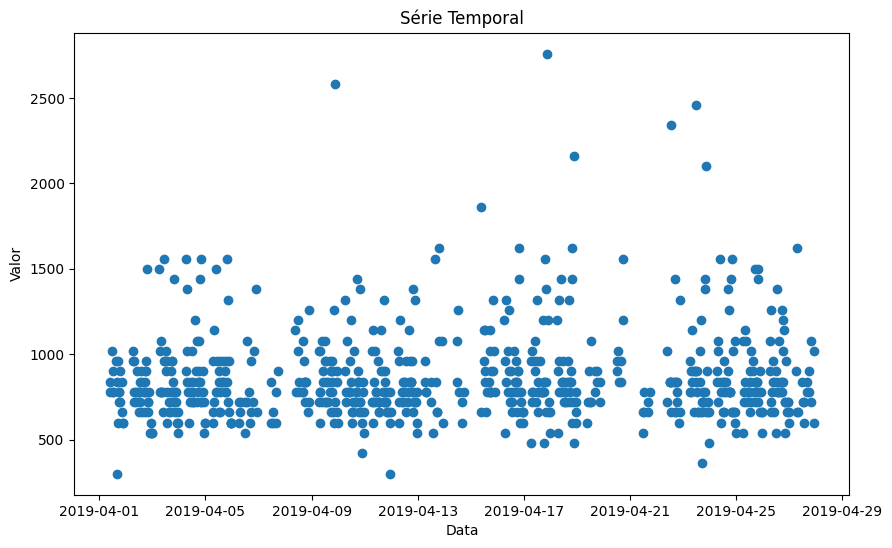

In [58]:
# Analisando o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico
print(df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem'))
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
# plt.show()

In [59]:
#Remoção dos outliers de cada Linha
# IQR Method (Interquartile Range):
def remove_outlier(valores):
    Q1 = np.percentile(valores,25)
    Q3 = np.percentile(valores,75)
    intervalo = Q3-Q1
    limite_superior = Q3+intervalo*1.5
    limite_inferior = Q1-intervalo*1.5
    return limite_superior,limite_inferior

linhas = df['Linha'].unique()
outliers_indexs = []
for linha in linhas:
    aux = df.loc[df['Linha'] == linha]['DuraçãoViagem']
    limite_superior,limite_inferior = remove_outlier(aux)
    aux = aux.loc[(aux.values > limite_superior) | (aux.values < limite_inferior)]
    outliers_indexs.extend(aux.index)
df.drop(outliers_indexs,inplace=True)
df.reset_index(drop=True,inplace=True)
df

C:\Users\Thiago\AppData\Local\Temp\ipykernel_1012\2474428967.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outliers_indexs,inplace=True)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
797202,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
797203,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
797204,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
797205,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


   Linha  DuraçãoViagem
0    362     178.799001
1    162     200.062211
2    271     200.500940
3    169     203.888001
4    168     211.184265
..   ...            ...
89   136     768.143369
90   135     788.268836
91   138     808.558630
92   235     848.243518
93  4122     864.089809

[94 rows x 2 columns]


Text(0.5, 1.0, 'Série Temporal')

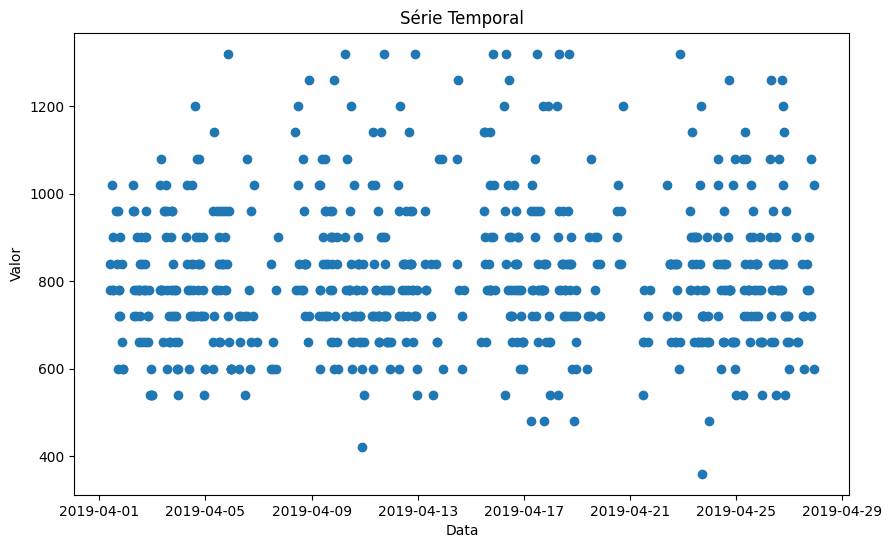

In [60]:
# Voltando a analisar o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico após a remoçao dos outliers
a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
# plt.show()

In [28]:
#Selecionando as rotas que serão usadas nos teste
a.iloc[[0,1,64,65,92,93]]

,Linha,DuraçãoViagem
0,362,178.799001
1,162,200.062211
64,605,518.593351
65,1123,530.362203
92,235,848.243518
93,4122,864.089809


In [29]:
# Deixando o dataframe apenas com as rotas que serão utilizadas
df = df.loc[df['Linha'].isin(['362','271','605','1120','235','4122'])].reset_index(drop=True).sort_values(by=['Linha','Ini'],ascending=[True,True])
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
29315,0,1120,3420,21,31.218,2018-11-06 06:10:00,2018-11-06 07:07:00,2,6,310,11,2,22.0
29316,0,1120,4560,26,31.218,2018-11-06 06:44:00,2018-11-06 08:00:00,2,6,310,11,2,22.0
29394,1,1120,3720,6,30.640,2018-11-06 07:08:00,2018-11-06 08:10:00,2,7,310,11,2,8.0
29317,0,1120,4320,30,31.218,2018-11-06 08:10:00,2018-11-06 09:22:00,2,8,310,11,2,11.0
29318,1,1120,3060,4,30.640,2018-11-06 08:14:00,2018-11-06 09:05:00,2,8,310,11,2,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35277,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0
35278,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0
35279,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5
35280,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0


In [30]:
# Dados gerais das rotas usadas
df.groupby('Linha').agg({'KmPerc':'max', 'Sentido':'count'})

,KmPerc,Sentido
Linha,,
1120,31.218,4582
235,24.110,4673
271,13.903,14001
362,4.240,8565
4122,25.244,4041
605,19.437,2864


In [31]:
print(df.shape)
len(df['Linha'].unique())

(38726, 13)


6

In [ ]:
# Exportando o Dataframe
df.to_csv('dados_floripa_tratado.csv',index=False)

# Criação dos Modelos e Testes

## Teste Inicial

### Função que cria os 3 modelos e salva seus resultados

In [ ]:
predictions = []
metrics = []

# Hyperparâmetros do XGBoosting
params_xgb = {
         "n_estimators": list(range(100, 1100, 100)), #Number of gradient boosted trees. Equivalent to number of boosting rounds
         "max_depth": list(range(2, 15)),#Maximum tree depth for base learners.
         "min_child_weight": list(range(1, 11)),#Minimum sum of instance weight(hessian) needed in a child.
         "learning_rate": [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],#Boosting learning rate (xgb’s “eta”)
         "gamma": np.arange(0, 0.7, 0.1)#Minimum loss reduction required to make a further partition on a leaf node of the tree.
        }

# Hyperparâmetros do Random Forest
params_rf = {
         "n_estimators": list(range(100, 1100, 100)),#The number of trees in the forest.
         "bootstrap": [True, False],#Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
         "max_depth": list(range(2, 15)),#The maximum depth of the tree.
         "max_features": [1.0, "sqrt", "log2"],#The number of features to consider when looking for the best split:
         "min_samples_leaf": list(range(1, 11)),#The minimum number of samples required to split an internal node
         "min_samples_split": list(range(2, 11)),#The minimum number of samples required to be at a leaf node.
        }

def cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome, randomizedSearch = False):

    #Treino do Modelo XGB e salvamento do tempo
    inicio_tempo_treino_xgb = datetime.now()
    modelo_xgb = xgb.XGBRegressor()

    if not randomizedSearch:
        modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])
    else:
        xgb_rand_search = RandomizedSearchCV(modelo_xgb, params_xgb, scoring="neg_mean_squared_error", n_iter=40, verbose=True, cv=10, n_jobs=-1, random_state=123)
        xgb_rand_search.fit(x_treino, y_treino)
        modelo_xgb = xgb_rand_search.best_estimator_

        modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

    fim_tempo_treino_xgb = datetime.now()
    tempo_treino_xgb = fim_tempo_treino_xgb - inicio_tempo_treino_xgb
    tempo_treino_xgb = float(f"{str(tempo_treino_xgb.seconds)}.{str(tempo_treino_xgb.microseconds)}")

    #Treino do Modelo RF e salvamento do tempo
    inicio_tempo_treino_rf = datetime.now()
    modelo_rf = RandomForestRegressor()

    if not randomizedSearch:
        modelo_rf.fit(x_treino, y_treino)
    else:
        rf_rand_search = RandomizedSearchCV(modelo_rf, params_rf, scoring="neg_mean_squared_error", n_iter=40, verbose=True, cv=10, n_jobs=-1, random_state=123)
        rf_rand_search.fit(x_treino, y_treino)
        modelo_rf = rf_rand_search.best_estimator_

        modelo_rf.fit(x_treino, y_treino)

    fim_tempo_treino_rf = datetime.now()
    tempo_treino_rf = fim_tempo_treino_rf - inicio_tempo_treino_rf
    tempo_treino_rf = float(f"{str(tempo_treino_rf.seconds)}.{str(tempo_treino_rf.microseconds)}")

    #Treino do Modelo LR e salvamento do tempo
    inicio_tempo_treino_lr = datetime.now()
    modelo_lr = LinearRegression()
    modelo_lr.fit(x_treino, y_treino)

    fim_tempo_treino_lr = datetime.now()
    tempo_treino_lr = fim_tempo_treino_lr - inicio_tempo_treino_lr
    tempo_treino_lr = float(f"{str(tempo_treino_lr.seconds)}.{str(tempo_treino_lr.microseconds)}")

    #Nomeando a coluna que receberá as previsões
    TesteNomeXGB = f"XGB - {teste_nome}"
    TesteNomeRF = f"RF - {teste_nome}"
    TesteNomeLR = f"LR - {teste_nome}"

    #Predição do XGB e salvamento do tempo
    inicio_tempo_previsao_xgb = datetime.now()
    df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
    fim_tempo_previsao_xgb = datetime.now()
    tempo_previsao_xgb = fim_tempo_previsao_xgb - inicio_tempo_previsao_xgb
    tempo_previsao_xgb = float(f"{str(tempo_previsao_xgb.seconds)}.{str(tempo_previsao_xgb.microseconds)}")

    #Predição do RF e salvamento do tempo
    inicio_tempo_previsao_rf = datetime.now()
    df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
    fim_tempo_previsao_rf = datetime.now()
    tempo_previsao_rf = fim_tempo_previsao_rf - inicio_tempo_previsao_rf
    tempo_previsao_rf = float(f"{str(tempo_previsao_rf.seconds)}.{str(tempo_previsao_rf.microseconds)}")

    #Predição do LR e salvamento do tempo
    inicio_tempo_previsao_lr = datetime.now()
    df_teste[f'{TesteNomeLR}'] = modelo_lr.predict(x_teste)
    fim_tempo_previsao_lr = datetime.now()
    tempo_previsao_lr = fim_tempo_previsao_lr - inicio_tempo_previsao_lr
    tempo_previsao_lr = float(f"{str(tempo_previsao_lr.seconds)}.{str(tempo_previsao_lr.microseconds)}")

    #Métricas do XGB
    RMSE_xgb = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"]))
    MAPE_xgb = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"])

    #Métricas do RF
    RMSE_rf = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"]))
    MAPE_rf = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"])

    #Métricas do LR
    RMSE_lr = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"]))
    MAPE_lr = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"])

    #Salvando as métricas num DataFrame Bonitinho
    metrics.append([f'{teste_nome}', rota,'XGBoost','RMSE',RMSE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'XGBoost','MAPE',MAPE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'Random Forest','RMSE',RMSE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Random Forest','MAPE',MAPE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','RMSE',RMSE_lr, tempo_treino_lr, tempo_previsao_lr])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','MAPE',MAPE_lr, tempo_treino_lr, tempo_previsao_lr])

    #Salvando as predições num DataFrame Bonitinho
    for i in range(df_teste.shape[0]):
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'XGBoost',df_teste[f"{TesteNomeXGB}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Random Forest',df_teste[f"{TesteNomeRF}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Linear Regression',df_teste[f"{TesteNomeLR}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Tempo real',df_teste["DuraçãoViagem"].iloc[i]])


    fi_xgb = pd.DataFrame(data=modelo_xgb.feature_importances_, index=modelo_xgb.feature_names_in_, columns=["importance"])
    fi_xgb["Teste"] = teste_nome
    fi_xgb = fi_xgb.reset_index().pivot(index="Teste", columns="index", values="importance")

    
    fi_rf = pd.DataFrame(data=modelo_rf.feature_importances_, index=x_treino.columns, columns=["importance"])
    fi_rf["Teste"] = teste_nome
    fi_rf = fi_rf.reset_index().pivot(index="Teste", columns="index", values="importance")

    return fi_xgb, fi_rf

### Execuções por rotas

In [ ]:
Colunas = [
    ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']
]
TestesNome = [
    "0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']"

]
importance = pd.DataFrame(columns=["KmPerc", "Sentido", "dia_ano", "dia_semana", "hora_dia", "mes_ano", "turno_dia", "TotalGirosMean"])

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])


In [ ]:
importance

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'MAPE'].sort_values(by='Valor')

In [ ]:
corr = df.corr()
corr

In [ ]:
# a.to_excel("Teste0.xlsx", index=False)
importance.to_excel("Results/Teste_0_importance.xlsx")
corr.to_excel("Results/Correlacao_Atributos.xlsx")

In [ ]:
rota = "4122"

a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == rota][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-08-04") & (df_plot["Ini"] < "2019-08-31")]
df_plot.set_index('Ini', inplace=True)

import matplotlib.dates as mdates

plt.figure(figsize=(30, 8))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylabel('Tempo de viagem (seg)', fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='both', width=3, length=6, pad=6)
plt.grid(axis="x")
plt.title(f'Linha {rota}', fontsize=20)
plt.tight_layout()
# plt.savefig(f"Images/rota_{rota}.svg")
# plt.show()


In [ ]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b

In [ ]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b["Data"] = pd.to_datetime(b["Data"]) 
b = b.sort_values(by=["Data"], ascending=False)

plt.figure(figsize=(100, 5))

plt.xlabel("Data")
plt.ylabel("Tempo Viagem")

b = b.loc[(b["Data"] > "2019-08-01") & (b["Data"] < "2019-08-28") & (b['Rota'] == '235')]

real_plor = b.loc[b['Modelo'] == 'Tempo real']
plt.plot(real_plor["Data"], real_plor["Valor"], color="#1f77b4", label="Real")

xgb_plot = b.loc[b['Modelo'] == 'XGBoost']
plt.plot(xgb_plot["Data"], xgb_plot["Valor"], color="#ff7f0e", label="XGB")

rf_plot = b.loc[b['Modelo'] == 'Random Forest']
plt.plot(rf_plot["Data"], rf_plot["Valor"], color="#d62728", label="RF")

lr_plot = b.loc[b['Modelo'] == 'Linear Regression']
plt.plot(lr_plot["Data"], lr_plot["Valor"], color="#9467bd", label="LR")

plt.legend()
# plt.show()
#plt.savefig(f"Images/previsao_235.jpg")

In [ ]:
df.loc[df["Linha"] == "4122"].groupby(["KmPerc", "Sentido"]).size()

In [ ]:
df.corr()

# Permuta

In [ ]:
Colunas = [
        ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['Sentido','dia_semana','hora_dia','dia_ano'],
        ['TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['dia_semana','hora_dia','dia_ano']
]
TestesNome = [
        "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']"
]


# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]

    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

In [ ]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost") ]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "Teste 0\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_index()
df

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_xgb.svg")
plt.savefig("Results/resultados_permutacao_xgb.png")


In [ ]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest") ]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "Teste 0\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor')

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_rf.svg")
plt.savefig("Results/resultados_permutacao_rf.png")



In [ ]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression") ]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "Teste 0\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor')

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_lr.svg")
plt.savefig("Results/resultados_permutacao_lr.png")



# Testes tempos anteriores

In [ ]:
df["DuraçãoViagem_1"] = df["DuraçãoViagem"]
df["DuraçãoViagem_2"] = df["DuraçãoViagem"]
df["DuraçãoViagem_3"] = df["DuraçãoViagem"]
df["DuraçãoViagem_4"] = df["DuraçãoViagem"]
df["DuraçãoViagem_5"] = df["DuraçãoViagem"]

df['DuraçãoViagem_1'] = df.groupby('Linha')['DuraçãoViagem'].shift(1)
df['DuraçãoViagem_2'] = df.groupby('Linha')['DuraçãoViagem'].shift(2)
df['DuraçãoViagem_3'] = df.groupby('Linha')['DuraçãoViagem'].shift(3)
df['DuraçãoViagem_4'] = df.groupby('Linha')['DuraçãoViagem'].shift(4)
df['DuraçãoViagem_5'] = df.groupby('Linha')['DuraçãoViagem'].shift(5)

df.dropna(subset=['DuraçãoViagem_5'] ,inplace=True)

df

In [ ]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"DuraçãoViagem": "mean"}).reset_index(drop=True)
df_mean.rename({"DuraçãoViagem": "DuraçãoViagemMean"}, axis=1, inplace=True)
df_mean

In [ ]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

In [ ]:
df["d-7"] = df["Ini"].dt.date - pd.Timedelta(days=7)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-7", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-7", "data"], axis=1, inplace=True)
df.rename(columns={"DuraçãoViagemMean_x": "DuraçãoViagemMean_d-1", "DuraçãoViagemMean_y": "DuraçãoViagemMean_d-7"}, inplace=True)
df

In [ ]:
Colunas = [
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7'],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4","DuraçãoViagem_5"]
]
TestesNome = [
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1]",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4','DuraçãoViagem_5']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[(a['Métrica'] == 'RMSE')].sort_values(by='Valor')

In [ ]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_tempos_anteriores_xgb.svg")
plt.savefig("Results/resultados_tempos_anteriores_xgb.png")


In [ ]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_tempos_anteriores_rf.svg")
plt.savefig("Results/resultados_tempos_anteriores_rf.png")

In [ ]:
b = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_tempos_anteriores_lr.svg")
plt.savefig("Results/resultados_tempos_anteriores_lr.png")

# Teste com clima

## Tratando dados de clima

In [ ]:
# Lendo os csv do Inmet e juntando os dois anos
clima2019 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2019_A_31-12-2019.CSV', sep=';', header=8, encoding='utf-8')
clima2018 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2018_A_31-12-2018.CSV', sep=';', header=8, encoding='utf-8')
clima2018.rename(columns = {'DATA (YYYY-MM-DD)': 'Data', 'HORA (UTC)':'Hora UTC'} ,inplace=True)
clima = pd.concat([clima2018,clima2019])
clima

In [ ]:
#Convertendo a data e a hora em um datetime
clima['Datetime'] = pd.to_datetime(clima['Data']+' '+clima['Hora UTC'],utc=True)
clima['Datetime'] = clima['Datetime'].dt.tz_convert(pytz.timezone('America/Sao_Paulo'))
clima['Datetime'] = clima['Datetime'].dt.tz_localize(None)
clima

In [ ]:
#Pegando apenas colunas com informações de data, precipitação e temperatudo. E o intervalo de tempo apenas dos nossos dados
clima = clima[['Datetime','PRECIPITACAO TOTAL, HORARIO (mm)','TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)']]
clima = clima.loc[(clima['Datetime'] >= '2018-10-01') & (clima['Datetime'] <= '2019-11-30')].sort_values(by='Datetime')
clima

In [ ]:
# Tirando a média das temperaturas mínima e máxima
clima["Temperatura Media"] = (clima["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float) + clima["TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float))/2

In [ ]:
#Transformando a precipitação em um valor categorico - Usamos apenas 3 Sem, Fraco e Forte pois com mais categorias algumas ficavam pouco representativas
clima["PRECIPITACAO TOTAL, HORARIO (mm)"] = clima["PRECIPITACAO TOTAL, HORARIO (mm)"].str.replace(",", ".").astype(float)
clima['Chuva'] = clima['PRECIPITACAO TOTAL, HORARIO (mm)'].apply(lambda x: 1 if (x > 0) & (x <= 2.5) else \
2 if (x > 2.5) & (x <= 10) else \
3 if (x > 10) else 0)

In [ ]:
#Transformando a Temperatura em um valor categorico - Usamos apenas 2 Frio ou Quente pois com mais categorias algumas ficavam pouco representativas
clima['Calor'] = clima['Temperatura Media'].apply(lambda x: 1 if (x > 16) & (x <= 25) else \
2 if (x > 25) else 0)

In [ ]:
#Dropando as colunas desnecessárias
clima.drop(["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)", "PRECIPITACAO TOTAL, HORARIO (mm)", "Temperatura Media"], axis=1, inplace=True)

In [ ]:
clima

In [ ]:
#Mudanças na data_partida para conseguir fazer o merge
df["Ini2"] = df["Ini"]
df["Ini2"] = df["Ini2"].dt.round("H")
#Merge dos dados e exclusão da coluna auxiliar
df = df.merge(clima, left_on="Ini2", right_on="Datetime", how="left")
df.drop(['Ini2','Datetime'],axis=1,inplace=True)
df

## Executando Testes

In [ ]:
df

In [ ]:
Colunas = [
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor'],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva'],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Calor'],
]
TestesNome = [
    "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']",
    "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva']",
    "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Calor']",
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])


In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

In [ ]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost")  & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost")  & (a["Teste"] == "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["Calor", "Chuva\ne calor", "Chuva", "Melhor\nanterior"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 17)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_xgb.svg")
plt.savefig("Results/resultados_clima_xgb.png")


In [ ]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest")  & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest")  & (a["Teste"] == "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["Calor", "Chuva\ne calor", "Chuva", "Melhor\nanterior"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 17)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_rf.svg")
plt.savefig("Results/resultados_clima_rf.png")


In [ ]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression")  & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression")  & (a["Teste"] == "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["Calor", "Chuva\ne calor", "Chuva", "Melhor\nanterior"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 22)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_lr.svg")
plt.savefig("Results/resultados_clima_lr.png")


# Teste com intervalor de treino diferentes

In [ ]:
Intervalos = ['2019-01-01','2019-03-01','2019-05-01','2019-07-01','2019-09-01']

TestesNome = [
    "4 Teste de Intervalos - 1 Janeiro",
    "4 Teste de Intervalos - 2 Março",
    "4 Teste de Intervalos - 3 Maio",
    "4 Teste de Intervalos - 4 Julho",
    "4 Teste de Intervalos - 5 Setembro"
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    for i in range(len(Intervalos)):
        df_teste = df_modelo.loc[df_modelo['Ini'] > Intervalos[i]]
        df_treino = df_modelo.loc[df_modelo['Ini'] <= Intervalos[i]]
        teste_nome = TestesNome[i]

        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

In [ ]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_treino_xgb.svg")
plt.savefig("Results/resultados_intervalo_treino_xgb.png")

In [ ]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_treino_rf.svg")
plt.savefig("Results/resultados_intervalo_treino_rf.png")

In [ ]:
b = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_treino_lr.svg")
plt.savefig("Results/resultados_intervalo_treino_lr.png")

In [ ]:
from dateutil.relativedelta import relativedelta
from datetime import date

Intervalos = ['2019-01-01','2019-03-01','2019-05-01','2019-07-01','2019-09-01']

TestesNome = [
    "4.1 Teste de Intervalos - 1 Janeiro",
    "4.1 Teste de Intervalos - 2 Março",
    "4.1 Teste de Intervalos - 3 Maio",
    "4.1 Teste de Intervalos - 4 Julho",
    "4.1 Teste de Intervalos - 5 Setembro"
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    for i in range(len(Intervalos)):
        df_teste = df_modelo.loc[(df_modelo['Ini'] > Intervalos[i]) & (df_modelo['Ini'] <= datetime.strptime(Intervalos[i], "%Y-%m-%d") + relativedelta(months=2))]
        df_treino = df_modelo.loc[df_modelo['Ini'] <= Intervalos[i]]
        teste_nome = TestesNome[i]

        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

In [ ]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4.1 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_2_treino_xgb.svg")
plt.savefig("Results/resultados_intervalo_2_treino_xgb.png")

In [ ]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4.1 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_2_treino_rf.svg")
plt.savefig("Results/resultados_intervalo_2_treino_rf.png")

In [ ]:
b = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4.1 Teste"))].sort_values("Teste")

plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)

for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    c["Valor"] = c["Valor"].diff()
    c["Valor"] = c["Valor"] * 100
    c.loc[c["Teste"] == "Janeiro", "Valor"] = 0
    c["Valor"] = c["Valor"].cumsum()
    
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format((c["Valor"].iloc[i]))
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
# plt.show()

plt.savefig("Results/resultados_intervalo_2_treino_lr.svg")
plt.savefig("Results/resultados_intervalo_2_treino_lr.png")

In [ ]:
pred = pd.DataFrame(predictions)

# Tunning

In [ ]:
TestesNome = [
    "5 Tunning",
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome, True)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')
a.to_excel("Results/resultados.xlsx")

In [ ]:
b = a[(a["Modelo"] != "Linear Regression") & (a["Métrica"] == "MAPE") & ((a["Teste"] == "5 Tunning") | (a["Teste"] == "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']"))]
b = b.pivot(index='Teste', columns=['Rota', 'Modelo'], values='Valor').sort_values("Teste")


In [ ]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & ((a["Teste"] == "5 Tunning") | (a["Teste"] == "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']"))]
b = b.pivot(index='Rota', columns=['Teste'], values='Valor')
b.rename(columns={"2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']": "Antes do Tunning"}, inplace=True)
b["Delta"] = b["Antes do Tunning"] - b["5 Tunning"]
b[["Antes do Tunning", "5 Tunning", "Delta"]] = b[["Antes do Tunning", "5 Tunning", "Delta"]] * 100
#dfi.export(b, 'Results/tunning_xgb.png')
b


In [ ]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & ((a["Teste"] == "5 Tunning") | (a["Teste"] == "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']"))]
b = b.pivot(index='Rota', columns=['Teste'], values='Valor')
b.rename(columns={"2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']": "Antes do Tunning"}, inplace=True)
b["Delta"] = b["Antes do Tunning"] - b["5 Tunning"]
b[["Antes do Tunning", "5 Tunning", "Delta"]] = b[["Antes do Tunning", "5 Tunning", "Delta"]] * 100
#dfi.export(b, 'Results/tunning_rf.png')
b
